In [32]:
#tensorflow.debugging.set_log_device_placement(True)

# !pip install opencv-python

import cv2
import random
import GPyOpt as gy
import noise as ns
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os

import time as time


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


tf.config.list_physical_devices('GPU')
#tf.test.is_built_with_cuda()

Num GPUs Available:  0


[]

In [4]:
main_path = os.path.dirname(os.path.abspath("Main.ipynb")) #path of main folder
data_path = os.path.join(main_path, "imagenet_val") #path of validation data

images = {}
classfiles = os.listdir(data_path)
print(classfiles)

for clf in classfiles:
    images[clf] = os.listdir(os.path.join(data_path,clf))


['n03125729', 'n02105855', 'n09193705', 'n04263257', 'n01751748']


In [5]:
images

{'n03125729': ['ILSVRC2012_val_00000005.JPEG'],
 'n02105855': ['ILSVRC2012_val_00000003.JPEG'],
 'n09193705': ['ILSVRC2012_val_00000002.JPEG'],
 'n04263257': ['ILSVRC2012_val_00000004.JPEG'],
 'n01751748': ['ILSVRC2012_val_00000001.JPEG']}

In [6]:
pretrained_model = tf.keras.applications.InceptionV3(
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.inception_v3.decode_predictions

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=6)[0]

imagesize = 299

2023-12-02 00:02:47.852910: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
class randomimg:
    
    def __init__(self):
        while True:
            print("NEW INSTANCE")
            self.count = 0
            cls = random.choice(classfiles)
            # print(images[cls])
            imgfile = random.choice(images[cls])
            # imgfile = images[cls]
            imgpath = os.path.join(data_path, cls+"/"+imgfile)
            # imgpath = imgfile
            # print(cls)
            print(imgfile)
            print(imgpath)
                
            rawimage = Image.open(imgpath)
            image = tf.keras.preprocessing.image.img_to_array(rawimage)

            image = tf.cast(image, tf.float32)
            image = image/255
            image = tf.image.resize(image, (imagesize, imagesize))
            image = image[None, ...]
            
            self.imgplot = rawimage 
            
            if np.shape(image) == (1,imagesize,imagesize,1):
                image = tf.image.grayscale_to_rgb(image)
            elif np.shape(image) == (1,imagesize,imagesize,4):
                image = tf.image.grayscale_to_rgb(image)
                
            print(np.shape(image))
            self.img = image
            self.image_probs = get_imagenet_label(pretrained_model.predict(image, steps=1))
            self.labelindex = np.argmax(pretrained_model.predict(image, steps=1))
            origpredictions = self.image_probs[0]

            actualprediction = os.path.basename(os.path.dirname(imgpath))

            # print(self.image_probs)

            if self.image_probs[0][0] == actualprediction:
                print(f"Imagenet prediction: {self.image_probs[0]}")
                print(f"Label: {actualprediction}")

                break

    def decision(self,img):
        self.count += 1
        # print(f"Count: {self.count}")
        check = get_imagenet_label(pretrained_model.predict(img, steps=1, verbose=0))
        if check[0][0] != self.image_probs[0][0]:
            return True
        else:
            return False


In [18]:
def display_images(image):
    guessdata = get_imagenet_label(pretrained_model.predict(image, steps=1))
    for guess in guessdata:
        print(guess[1] + ": " + str(guess[2]))
        
    plt.figure()
    plt.imshow(image[0])
 # plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                 #  label, confidence*100))
    plt.show()

In [19]:
def norm (image, image2):
    y = image[0]
    z = image2[0]
    l2norm = tf.norm(np.subtract(z,y), ord=2).numpy()
    infnorm = tf.norm(np.subtract(z,y), ord=np.inf).numpy()
    return l2norm, infnorm

In [20]:
def select_delta(dist, l, cur_iter, theta, d):
    if cur_iter == 1:
        delta = 0.1
    else:
        if l == 'l2':
            delta=np.sqrt(d)*theta*dist
        elif l == 'linf':
            delta=np.sqrt(d)*theta*dist
    return delta

In [21]:
def clip_image(image, clip_min, clip_max):
	# Clip an image, or an image batch, with upper and lower threshold.
	return np.minimum(np.maximum(clip_min, image), clip_max)

NEW INSTANCE
ILSVRC2012_val_00000002.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n09193705/ILSVRC2012_val_00000002.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 120ms/step
NEW INSTANCE
ILSVRC2012_val_00000001.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n01751748/ILSVRC2012_val_00000001.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 138ms/step
Imagenet prediction: ('n01751748', 'sea_snake', 0.7595439)
Label: n01751748
1/1 [==============================] - 0s 91ms/step
nematode: 0.20051646
sea_snake: 0.19653398
water_snake: 0.17694283
American_alligator: 0.036404714
stingray: 0.032495815
leatherback_turtle: 0.024659488


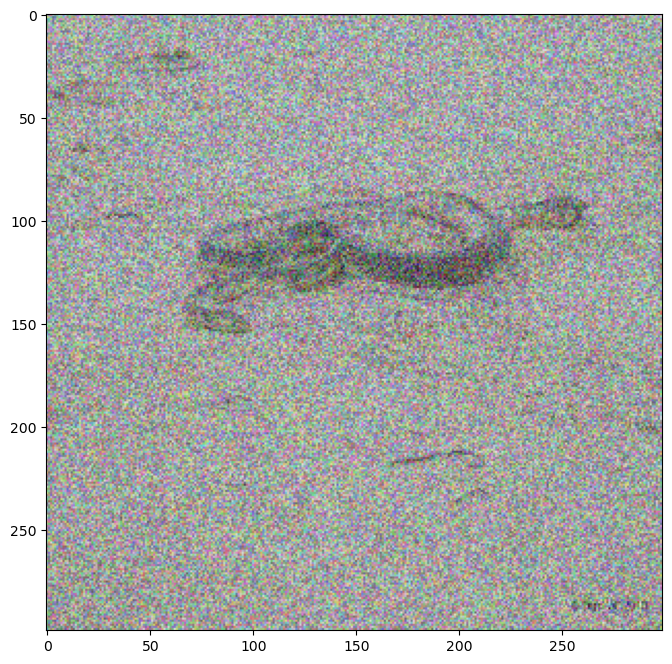

In [22]:
def random_noise_hsja(imgobj):
    tries = 0
    while tries < 1000:
        tries += 1
        noise = np.random.uniform(0,1,[1,imagesize,imagesize,3])
        if imgobj.decision(noise):
            break
    
    lo = 0.0
    hi = 1.0
    while hi - lo > 0.001:
        mid = (hi + lo) / 2.0
        blended = (1 - mid) * imgobj.img + mid * noise 
        if imgobj.decision(blended):
            hi = mid
        else:
            lo = mid
    
    final = (1 - hi) * imgobj.img + hi * noise
    return final

i = randomimg()
display_images(random_noise_hsja(i))

In [23]:
def project(original_image, perturbed_image, alphas, l):
    
    #alphas_shape = len(original_image.shape)
    #alphas = alphas.reshape(alphas_shape)
    if l == 'l2':
        return (1-alphas) * original_image + alphas * perturbed_image
    elif l == 'linf':
        out_images = clip_image(
            perturbed_image, 
            original_image - alphas, 
            original_image + alphas
        )
        return out_images
    
def binary_search_hsja(perturbed, imgobj, theta, l='l2'):
    
    distances = []
    for p in perturbed:
        if l == 'l2':
            distances.append(norm(p, imgobj.img)[0])
        else:
            distances.append(norm(p, imgobj.img)[1])    
    distances = np.array(distances)
    if l == 'linf':
        highs = distances
        thresholds = np.minimum(distances * theta, theta)
    else:
        highs = np.ones(len(perturbed))
        thresholds = theta

    lows = np.zeros(len(perturbed))
    
    while np.max((highs - lows) / thresholds) > 1:
        
        mids = (highs + lows) / 2.0
        
        decisions = np.array([])
        
        for p in range(len(perturbed)):
            mid_image = project(imgobj.img, perturbed[p], mids[p], l)
            d = imgobj.decision(mid_image)
            decisions = np.append(decisions, [d])
            
        # Update highs and lows based on model decisions.
        
        lows = np.where(decisions == 0, mids, lows)
        highs = np.where(decisions == 1, mids, highs)


    outputs = [project(imgobj.img, perturbed[p], highs[p], l) for p in range(len(perturbed))]
    
    finaldists = []
    for p in perturbed:
        if l == 'l2':
            finaldists.append(norm(p, imgobj.img)[0])
        else:
            finaldists.append(norm(p, imgobj.img)[1])
            
    idx = np.argmin(finaldists)

    dist = distances[idx]
    out_image = outputs[idx]
    return out_image, dist

        


#fin = binary_search_hsja([random_noise_hsja(im),random_noise_hsja(im)], im, theta, 'l2')

#print("Dist: "+str(fin[1]))

#delt  = select_delta(fin[1],constraint, 2, theta, d)

In [29]:
def approximate_gradient(sample, num_evals, delta, l):
    clip_max=1
    clip_min =1

    noise_shape = [num_evals] + list(sample.shape)
    if l == 'l2':
        rv = np.random.randn(*noise_shape)
    elif l == 'linf':
        rv = np.random.uniform(low = -1, high = 1, size = noise_shape)
    
    rv = rv / np.sqrt(np.sum(rv ** 2, axis = (1,2,3), keepdims = True))
    perturbed = sample + delta * rv
    #perturbed = clip_image(perturbed, clip_min, clip_max)
    rv = (perturbed - sample) / delta
    
    decisions = np.array([])
    for i in range(num_evals):
        check1 = get_imagenet_label(pretrained_model.predict(perturbed[i], steps=1, verbose=0))
        check2 = get_imagenet_label(pretrained_model.predict(sample, steps=1, verbose=0))
        boolean = [check1[0][0] != check2[0][0]]
        decisions = np.append(decisions, boolean)

    decision_shape = [len(decisions)] + [1] * len(sample.shape)
    fval = 2 * decisions.astype(float).reshape(decision_shape) - 1.0

    if np.mean(fval) == 1.0: # label changes. 
        gradf = np.mean(rv, axis = 0)
    elif np.mean(fval) == -1.0: # label not change.
        gradf = - np.mean(rv, axis = 0)
    else:
        fval -= np.mean(fval)
        gradf = np.mean(fval * rv, axis = 0) 

    # Get the gradient direction.
    gradf = gradf / np.linalg.norm(gradf)

    return gradf

#gradf = approximate_gradient(fin[0], 50, delt, constraint)
#display_images(i)

In [30]:
def geometric_progression(x, update, dist, cur_iter):

    epsilon = dist / np.sqrt(cur_iter) 

    def phi(epsilon):
        new = x + epsilon * update
        check1 = get_imagenet_label(pretrained_model.predict(new, steps=1))
        check2 = get_imagenet_label(pretrained_model.predict(x, steps=1))
        success = [check1[0][0] != check2[0][0]]
        return success

    while not phi(epsilon):
        epsilon /= 2.0

    return epsilon

#geometric_progression(fin[0], gradf, fin[1], 20)

In [31]:
def hsja(imgobj, #instance of class randomimg
            constraint = 'l2',
            num_iterations = 30,
            gamma = 1,
            max_num_evals = 1e4,
            init_num_evals = 100,
            verbose = True
            ):
    d = np.prod(imgobj.img.shape)
    
    if constraint == 'l2':
        theta = gamma / d**(3/2)
    else:
        theta = gamma / d**2
        
    perturbed = random_noise_hsja(imgobj)
    
    perturbed, dist_post = binary_search_hsja([perturbed], imgobj, theta, constraint)
    
    if constraint == 'l2': 
        
        dist = norm(perturbed, imgobj.img)[0]
        print(dist)
    else:
        dist = norm(perturbed, imgobj.img)[1]
    
    for j in np.arange(num_iterations):
        print('start')
        c_iter = j + 1

        # Choose delta.
        start_time = time.time()
        delta = select_delta(dist, constraint, c_iter, theta, d)
        print('Select Delta Time:', time.time() - start_time)

        print("Delta" + str(delta))
        # Choose number of evaluations.
        num_evals = int(init_num_evals * np.sqrt(c_iter))
        num_evals = int(min([num_evals, max_num_evals]))
        
        # approximate gradient.
        start_time = time.time()
        gradf = approximate_gradient(perturbed, num_evals, 
            delta, constraint)
        print('Approximate Gradient Time:', time.time() - start_time)
        
        if constraint == 'linf':
            update = np.sign(gradf)
        else:
            update = gradf
        # find step size.
        start_time = time.time()
        epsilon = geometric_progression(perturbed, 
        update, dist, c_iter)
        print('Geometric Progression Time:', time.time() - start_time)
        print(epsilon)
        # Update the sample. 
        perturbed =  perturbed + epsilon * update

        # Binary search to return to the boundary. 
        start_time = time.time()
        perturbed, dist_post = binary_search_hsja(perturbed, imgobj, theta, constraint)
        print('Binary Search Time:', time.time() - start_time)
        
        # compute new distance.
        if constraint == 'l2': 
            dist = norm(perturbed, imgobj.img)[0]
        else:
            dist = norm(perturbed, imgobj.img)[1]
            
        if verbose:
            print('iteration: {:d}, {:s} distance {:.4E}'.format(j+1, constraint, dist))

    return perturbed

i = randomimg()
hsja = hsja(i, constraint = 'linf', num_iterations=1)
display_images(hsja)

NEW INSTANCE
ILSVRC2012_val_00000002.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n09193705/ILSVRC2012_val_00000002.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 155ms/step
NEW INSTANCE
ILSVRC2012_val_00000001.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n01751748/ILSVRC2012_val_00000001.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 196ms/step
Imagenet prediction: ('n01751748', 'sea_snake', 0.7595439)
Label: n01751748
start
Delta0.1


KeyboardInterrupt: 

In [31]:
i.count

1158